In [ ]:
from copy import copy
import torch
import torch.nn as nn
import torchvision
from torchvision.models import resnet50, ResNet50_Weights

import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

import os
from tqdm import tqdm
from torchvision.models.resnet import Bottleneck

import timm

import torch.nn.functional as F

from PIL import Image

from torchvision.models import vgg19, VGG19_Weights

import copy

import random
import torchvision.transforms.functional as TF

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import pandas as pd
from datasets import load_dataset

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available()
                      else "mps" if hasattr(torch.backends, "mps") and torch.backends.mps.is_available()
                      else "cpu")
print(f"Device: {device}")

weights_default = ResNet50_Weights.DEFAULT

Device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Base Model Import

In [ ]:
model = resnet50(weights=weights_default).to(device)
resnet50_base_model = copy.copy(model)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]


In [ ]:
vit_base_model = timm.create_model("vit_small_patch16_224", pretrained=True)

# Replace head for STL-10 (10 classes)
vit_base_model.head = nn.Linear(vit_base_model.head.in_features, 10)

vit_base_model = vit_base_model.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

###Dataset Import

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize to match ResNet/ViT input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])


trainset = torchvision.datasets.STL10(root="./data", split='train',
                                      download=True, transform=transform_train)
testset = torchvision.datasets.STL10(root="./data", split='test',
                                     download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

print(f"Train size: {len(trainset)}, Test size: {len(testset)}")


100%|██████████| 2.64G/2.64G [00:33<00:00, 79.6MB/s]


Train size: 5000, Test size: 8000


In [ ]:
def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(12, 6))  # increase figure size (W,H)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # CHW -> HWC
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

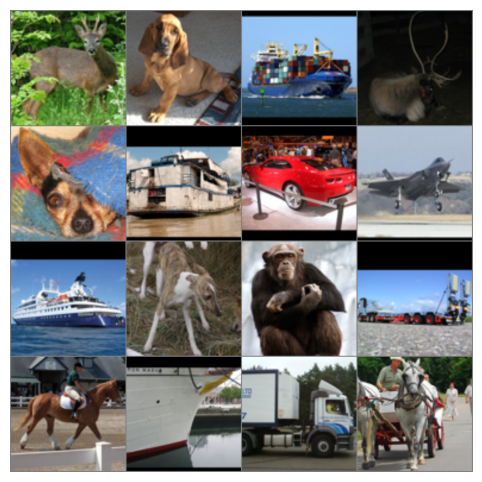

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:16], nrow=4))

###Finetuning ResNet50

In [ ]:
num_ftrs = resnet50_base_model.fc.in_features
resnet50_base_model.fc = nn.Linear(num_ftrs, 10)   # STL-10 has 10 classes
resnet50_base_model = resnet50_base_model.to(device)

In [ ]:
resnet50_base_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50_base_model.parameters(), lr=0.001)

In [ ]:
def train_model(model, trainloader, testloader, criterion, optimizer, epochs=5, log_interval=100):
    history = {"train_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        # Training Loop
        for batch_idx, (images, labels) in enumerate(trainloader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # 🔹 Print progress every log_interval batches
            if (batch_idx + 1) % log_interval == 0:
                print(f"Epoch [{epoch+1}/{epochs}] "
                      f"Step [{batch_idx+1}/{len(trainloader)}] "
                      f"Loss: {loss.item():.4f} | "
                      f"Train Acc (so far): {100*correct/total:.2f}%")

        # End of epoch summary
        train_acc = 100 * correct / total
        avg_loss = running_loss / len(trainloader)

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        test_acc = 100 * correct / total

        print(f"✅ Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {avg_loss:.4f} | "
              f"Train Acc: {train_acc:.2f}% | "
              f"Val Acc: {test_acc:.2f}%\n")

        history["train_loss"].append(avg_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(test_acc)

    return model, history

In [ ]:
resnet50_finetuned_model, resnet50_history = train_model(resnet50_base_model, trainloader, testloader, criterion, optimizer, epochs=10)

✅ Epoch [1/10] Train Loss: 0.6068 | Train Acc: 81.24% | Val Acc: 78.08%

✅ Epoch [2/10] Train Loss: 0.2711 | Train Acc: 91.50% | Val Acc: 80.62%

✅ Epoch [3/10] Train Loss: 0.2098 | Train Acc: 93.22% | Val Acc: 82.08%

✅ Epoch [4/10] Train Loss: 0.1589 | Train Acc: 95.06% | Val Acc: 86.65%

✅ Epoch [5/10] Train Loss: 0.1518 | Train Acc: 95.16% | Val Acc: 82.45%

✅ Epoch [6/10] Train Loss: 0.0940 | Train Acc: 96.96% | Val Acc: 88.29%

✅ Epoch [7/10] Train Loss: 0.0643 | Train Acc: 98.10% | Val Acc: 87.16%

✅ Epoch [8/10] Train Loss: 0.1964 | Train Acc: 93.84% | Val Acc: 73.94%

✅ Epoch [9/10] Train Loss: 0.0966 | Train Acc: 96.90% | Val Acc: 86.70%

✅ Epoch [10/10] Train Loss: 0.0737 | Train Acc: 97.66% | Val Acc: 86.30%



In [ ]:
# Save model (architecture + weights)
torch.save(resnet50_finetuned_model, "/content/drive/MyDrive/PA_1_Finetuned_Models/resnet50_stl10_full.pth")
print("Model saved to Google Drive ✅")

Model saved to Google Drive ✅


###Finetuning ViT-16/S

In [ ]:
vit_base_model = timm.create_model("vit_small_patch16_224", pretrained=True)

# Replace head for STL-10 (10 classes)
vit_base_model.head = nn.Linear(vit_base_model.head.in_features, 10)

vit_base_model = vit_base_model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit_base_model.parameters(), lr=1e-4)

In [ ]:
vit_base_model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [ ]:
vit_finetuned_model, vit_history = train_model(vit_base_model, trainloader, testloader, criterion, optimizer, epochs=10)

✅ Epoch [1/10] Train Loss: 0.2179 | Train Acc: 93.00% | Val Acc: 97.78%

✅ Epoch [2/10] Train Loss: 0.0268 | Train Acc: 99.22% | Val Acc: 97.76%

✅ Epoch [3/10] Train Loss: 0.0089 | Train Acc: 99.74% | Val Acc: 98.08%

✅ Epoch [4/10] Train Loss: 0.0006 | Train Acc: 100.00% | Val Acc: 98.59%

✅ Epoch [5/10] Train Loss: 0.0003 | Train Acc: 100.00% | Val Acc: 98.58%

✅ Epoch [6/10] Train Loss: 0.0002 | Train Acc: 100.00% | Val Acc: 98.55%

✅ Epoch [7/10] Train Loss: 0.0002 | Train Acc: 100.00% | Val Acc: 98.60%

✅ Epoch [8/10] Train Loss: 0.0001 | Train Acc: 100.00% | Val Acc: 98.64%

✅ Epoch [9/10] Train Loss: 0.0001 | Train Acc: 100.00% | Val Acc: 98.64%

✅ Epoch [10/10] Train Loss: 0.0001 | Train Acc: 100.00% | Val Acc: 98.66%



In [ ]:
# Save whole ViT model (architecture + weights)
torch.save(vit_finetuned_model, "/content/drive/MyDrive/PA_1_Finetuned_Models/vit_small_stl10_full.pth")
print("ViT model saved to Google Drive ✅")

ViT model saved to Google Drive ✅


###ResNet50 vs ViT-S/16 Comparison

In [ ]:
def plot_history(hist1, hist2, label1="ResNet-50", label2="ViT-S/16"):
    epochs = range(1, len(hist1["train_loss"]) + 1)

    plt.figure(figsize=(12,5))

    # Loss Curve
    plt.subplot(1,2,1)
    plt.plot(epochs, hist1["train_loss"], label=f"{label1} Loss")
    plt.plot(epochs, hist2["train_loss"], label=f"{label2} Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.legend()

    # Accuracy Curve
    plt.subplot(1,2,2)
    plt.plot(epochs, hist1["train_acc"], label=f"{label1} Train Acc")
    plt.plot(epochs, hist1["val_acc"], '--', label=f"{label1} Val Acc")
    plt.plot(epochs, hist2["train_acc"], label=f"{label2} Train Acc")
    plt.plot(epochs, hist2["val_acc"], '--', label=f"{label2} Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Curve")
    plt.legend()

    plt.show()

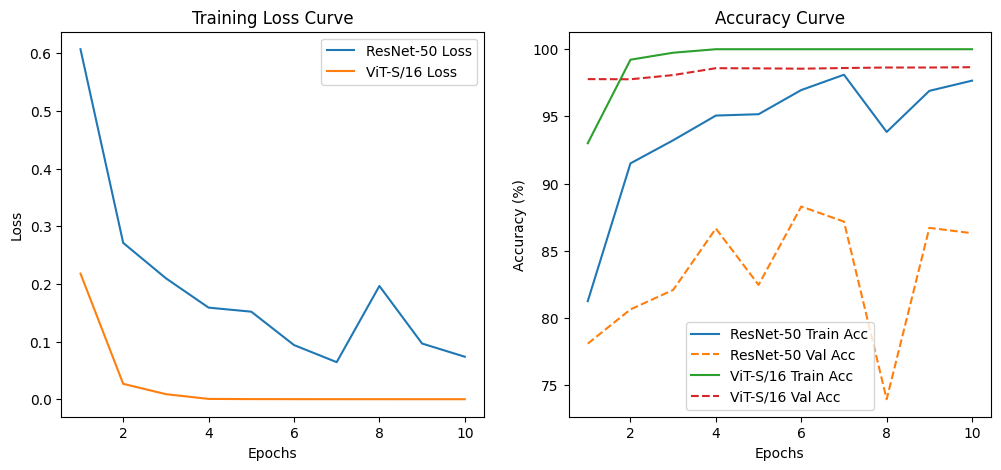

In [ ]:
plot_history(resnet50_history, vit_history)

####1. Baseline Accuracy (In-Distribution)

In [ ]:
def evaluate_model(model, dataloader):
    test_acc = []
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            test_acc.append(100 * correct / total)
    return test_acc


In [ ]:
def plot_test_acc(model1_acc, model1_label, model2_acc, model2_label):
    plt.figure(figsize=(12,5))
    plt.plot(range(1, len(model1_acc)+1), model1_acc, label=model1_label)
    plt.plot(range(1, len(model2_acc)+1), model2_acc, label=model2_label)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Curve")
    plt.legend()
    plt.show()

In [ ]:
resnet_acc = evaluate_model(resnet50_finetuned_model, testloader)
vit_acc = evaluate_model(vit_finetuned_model, testloader)

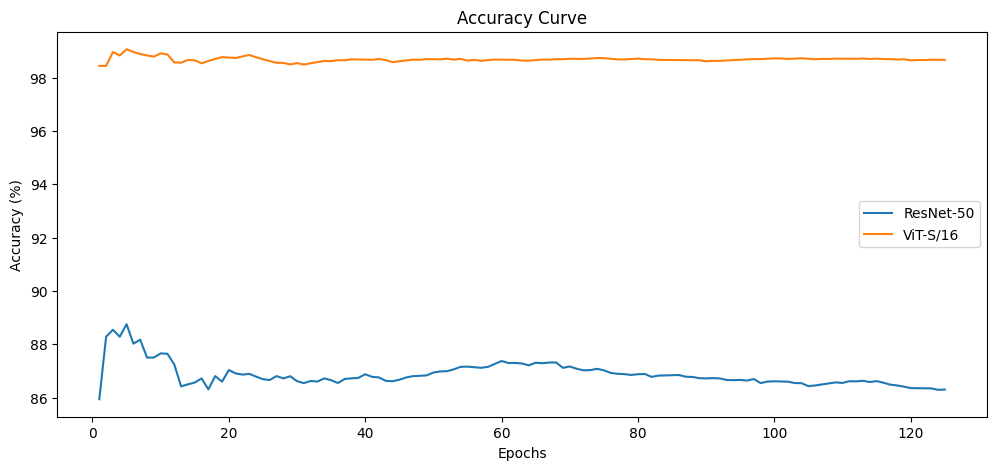

In [ ]:
plot_test_acc(resnet_acc, "ResNet-50", vit_acc, "ViT-S/16")

####2. Color Bias Test

In [ ]:
transform_gray = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # keep 3 channels for model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

gray_testset = torchvision.datasets.STL10(root="./data", split='test',
                                          download=True, transform=transform_gray)
gray_testloader = DataLoader(gray_testset, batch_size=64, shuffle=False)


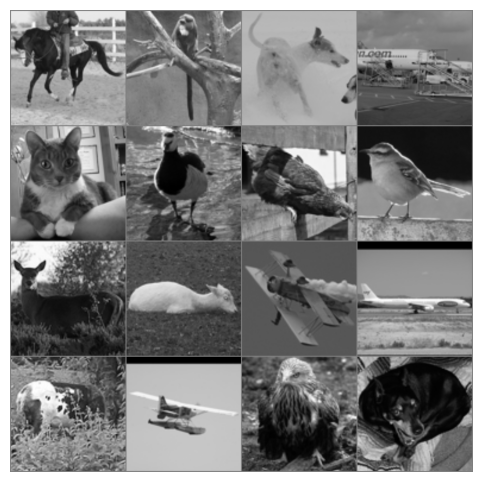

In [ ]:
grey_dataiter = iter(gray_testloader)
grey_images, grey_labels = next(grey_dataiter)

imshow(torchvision.utils.make_grid(grey_images[:16], nrow=4))

In [ ]:
resnet_gray_acc = evaluate_model(resnet50_finetuned_model, gray_testloader)
vit_gray_acc = evaluate_model(vit_finetuned_model, gray_testloader)

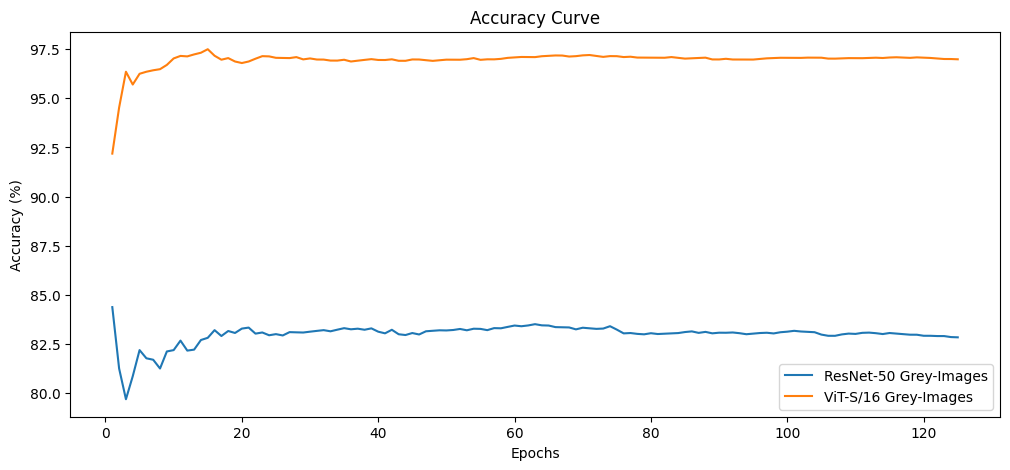

In [ ]:
plot_test_acc(resnet_gray_acc, "ResNet-50 Grey-Images", vit_gray_acc, "ViT-S/16 Grey-Images")

####3. Shape vs. Texture Bias – Stylized Images

In [ ]:
# (1) Pick 10 random content indices:
import random


class_names = ['airplane','bird','car','cat','deer','dog','horse','monkey','ship','truck']

content_indices = random.sample(range(len(trainset)), 10)

# (2) For each content image, pick a style image of a different class:
style_indices = []
for ci in content_indices:
    content_label = trainset[ci][1]
    # all indices not of the same class
    candidates = [i for i in range(len(trainset)) if trainset[i][1] != content_label]
    style_indices.append(random.choice(candidates))

# Show chosen class pairs:
for i, (c_idx, s_idx) in enumerate(zip(content_indices, style_indices)):
    c_name = class_names[trainset[c_idx][1]]
    s_name = class_names[trainset[s_idx][1]]
    print(f"Pair {i}: content (shape) = {c_name},  style (texture) = {s_name}")


Pair 0: content (shape) = cat,  style (texture) = ship
Pair 1: content (shape) = bird,  style (texture) = deer
Pair 2: content (shape) = car,  style (texture) = monkey
Pair 3: content (shape) = horse,  style (texture) = car
Pair 4: content (shape) = monkey,  style (texture) = horse
Pair 5: content (shape) = bird,  style (texture) = ship
Pair 6: content (shape) = horse,  style (texture) = car
Pair 7: content (shape) = truck,  style (texture) = ship
Pair 8: content (shape) = monkey,  style (texture) = airplane
Pair 9: content (shape) = truck,  style (texture) = car


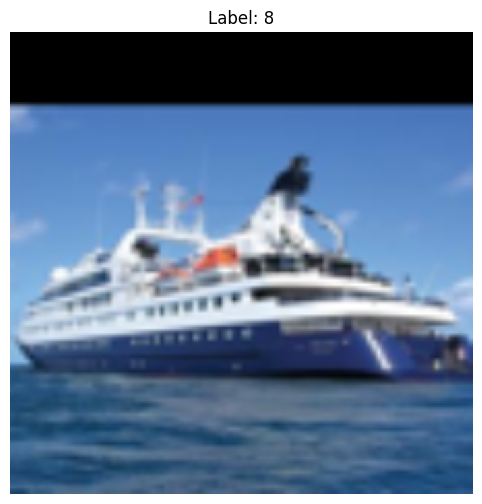

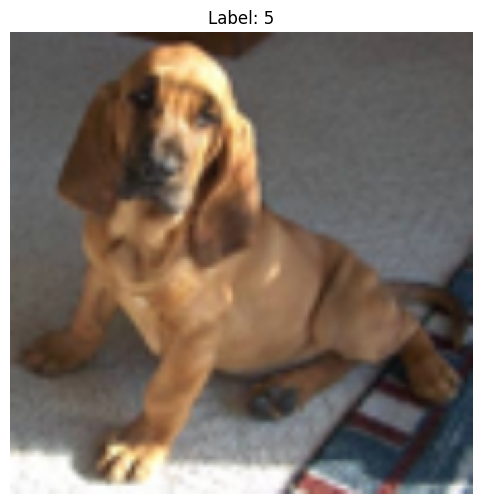

In [ ]:
content_image = images[8]
content_label = labels[8]

imshow(content_image, title=f"Label: {content_label}")

style_image = images[1]
style_label = labels[1]

imshow(style_image, title=f"Label: {style_label}")

####4. Translation Invariance Test:

In [ ]:
class TranslateTransform:
    def __init__(self, shift):
        self.shift = shift
    def __call__(self, x):
        return transforms.functional.affine(x, angle=0, translate=self.shift, scale=1.0, shear=0)

transform_shift = transforms.Compose([
    transforms.Resize((224, 224)),
    TranslateTransform((5, 5)),  # shift right+down by 5 pixels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

In [ ]:
shift_testset = torchvision.datasets.STL10(root="./data", split='test',
                                           download=True, transform=transform_shift)
shift_testloader = DataLoader(shift_testset, batch_size=64, shuffle=False)

In [ ]:
resnet_shift_acc = evaluate_model(resnet50_finetuned_model, shift_testloader)
vit_shift_acc = evaluate_model(vit_finetuned_model, shift_testloader)

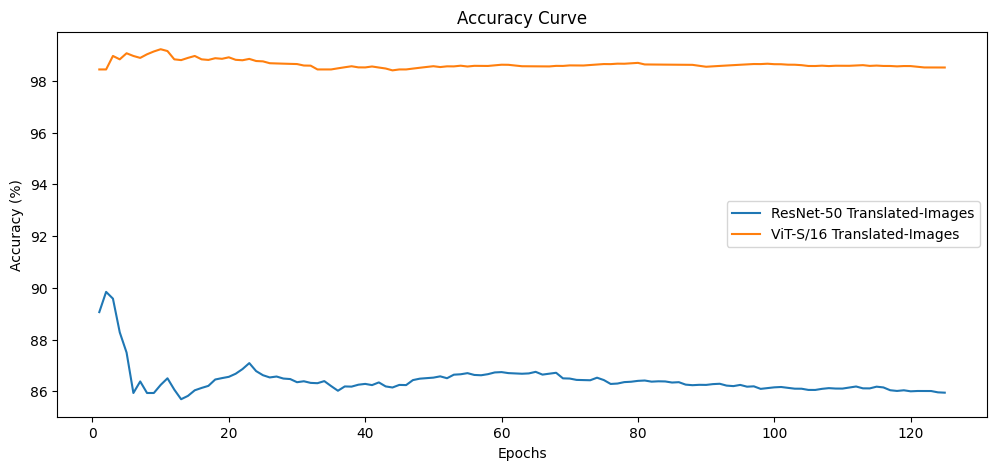

In [ ]:
plot_test_acc(resnet_shift_acc, "ResNet-50 Translated-Images", vit_shift_acc, "ViT-S/16 Translated-Images")

In [ ]:
def translation_invariance_test(model, clean_loader, shifted_loader):
    model.eval()
    correct, total = 0, 0
    consistent, total_consistency = 0, 0

    all_preds_clean, all_preds_shifted = [], []

    with torch.no_grad():
        for (imgs_clean, labels_clean), (imgs_shift, labels_shift) in zip(clean_loader, shifted_loader):
            imgs_clean, labels_clean = imgs_clean.to(device), labels_clean.to(device)
            imgs_shift, labels_shift = imgs_shift.to(device), labels_shift.to(device)

            # Predictions on clean images
            out_clean = model(imgs_clean)
            _, pred_clean = out_clean.max(1)

            # Predictions on shifted images
            out_shift = model(imgs_shift)
            _, pred_shift = out_shift.max(1)

            # Accuracy on shifted set
            total += labels_shift.size(0)
            correct += pred_shift.eq(labels_shift).sum().item()

            # Consistency check
            total_consistency += labels_clean.size(0)
            consistent += pred_clean.eq(pred_shift).sum().item()

    shifted_acc = 100 * correct / total
    consistency = 100 * consistent / total_consistency

    return shifted_acc, consistency


In [ ]:
resnet_shift_acc, resnet_consistency = translation_invariance_test(resnet50_finetuned_model, testloader, shift_testloader)
vit_shift_acc, vit_consistency = translation_invariance_test(vit_finetuned_model, testloader, shift_testloader)

print(f"📦 ResNet-50 | Shifted Acc: {resnet_shift_acc:.2f}% | Consistency: {resnet_consistency:.2f}%")
print(f"📦 ViT-S/16  | Shifted Acc: {vit_shift_acc:.2f}% | Consistency: {vit_consistency:.2f}%")

📦 ResNet-50 | Shifted Acc: 85.95% | Consistency: 91.69%
📦 ViT-S/16  | Shifted Acc: 98.51% | Consistency: 98.90%


In [ ]:
print("---------------------------------------------------------")
print(f"{'Model':<10} | {'Shifted Accuracy (%)':<20} | {'Consistency (%)':<15}")
print("---------------------------------------------------------")
print(f"{'ResNet-50':<10} | {resnet_shift_acc:<20.2f} | {resnet_consistency:<15.2f}")
print(f"{'ViT-S/16':<10} | {vit_shift_acc:<20.2f} | {vit_consistency:<15.2f}")
print("---------------------------------------------------------")

---------------------------------------------------------
Model      | Shifted Accuracy (%) | Consistency (%)
---------------------------------------------------------
ResNet-50  | 85.95                | 91.69          
ViT-S/16   | 98.51                | 98.90          
---------------------------------------------------------


####5. Permutation Occlusion Test:

#####a. Occlusion

In [ ]:
class RandomOcclusion:
    def __init__(self, size=50):
        self.size = size
    def __call__(self, img):
        img = transforms.ToTensor()(img)   # convert to tensor first
        c, h, w = img.shape
        x = random.randint(0, w - self.size)
        y = random.randint(0, h - self.size)
        img[:, y:y+self.size, x:x+self.size] = 0.0   # black patch
        return img

In [ ]:
transform_occlude = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=1.0, scale=(0.1, 0.1), ratio=(1.0, 1.0), value=0),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

In [ ]:
occlude_testset = torchvision.datasets.STL10(root="./data", split='test',
                                             download=True, transform=transform_occlude)
occlude_testloader = DataLoader(occlude_testset, batch_size=64, shuffle=False)

In [ ]:
resnet_occ_acc_list = evaluate_model(resnet50_finetuned_model, occlude_testloader)
vit_occ_acc_list = evaluate_model(vit_finetuned_model, occlude_testloader)

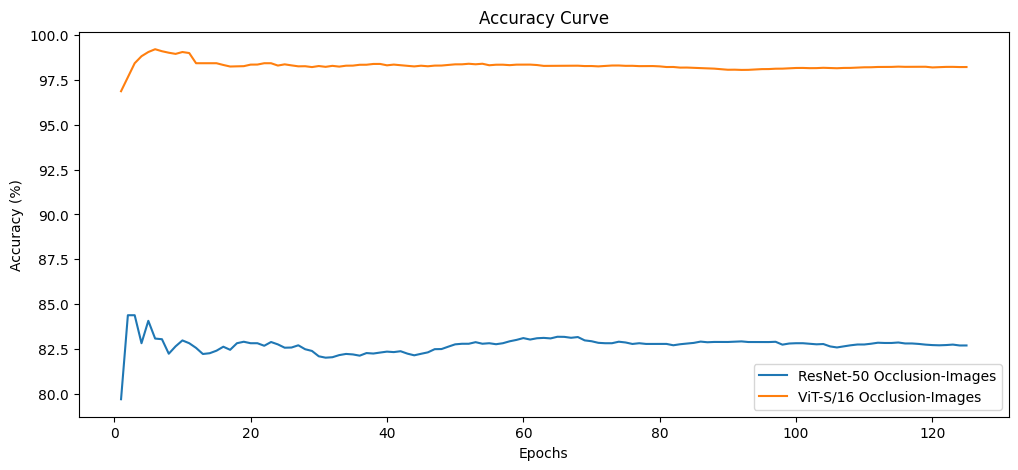

In [ ]:
plot_test_acc(resnet_occ_acc_list, "ResNet-50 Occlusion-Images", vit_occ_acc_list, "ViT-S/16 Occlusion-Images")

In [ ]:
def occlusion_invariance_test(model, clean_loader, occluded_loader):
    model.eval()
    correct, total = 0, 0
    consistent, total_consistency = 0, 0

    all_preds_clean, all_preds_occluded = [], []

    with torch.no_grad():
        for (imgs_clean, labels_clean), (imgs_occ, labels_occ) in zip(clean_loader, occluded_loader):
            imgs_clean, labels_clean = imgs_clean.to(device), labels_clean.to(device)
            imgs_occ, labels_occ = imgs_occ.to(device), labels_occ.to(device)

            # Predictions on clean images
            out_clean = model(imgs_clean)
            _, pred_clean = out_clean.max(1)

            # Predictions on occluded images
            out_occ = model(imgs_occ)
            _, pred_occ = out_occ.max(1)

            # Accuracy on occluded set
            total += labels_occ.size(0)
            correct += pred_occ.eq(labels_occ).sum().item()

            # Consistency check
            total_consistency += labels_clean.size(0)
            consistent += pred_clean.eq(pred_occ).sum().item()

    occluded_acc = 100 * correct / total
    consistency = 100 * consistent / total_consistency

    return occluded_acc, consistency


In [ ]:
resnet_occ_acc, resnet_occ_consistency = occlusion_invariance_test(resnet50_finetuned_model, testloader, occlude_testloader)
vit_occ_acc, vit_occ_consistency = occlusion_invariance_test(vit_finetuned_model, testloader, occlude_testloader)

print(f"📦 ResNet-50 | Occluded Acc: {resnet_shift_acc:.2f}% | Consistency: {resnet_occ_consistency:.2f}%")
print(f"📦 ViT-S/16  | Occluded Acc: {vit_shift_acc:.2f}% | Consistency: {vit_occ_consistency:.2f}%")

📦 ResNet-50 | Occluded Acc: 85.95% | Consistency: 91.96%
📦 ViT-S/16  | Occluded Acc: 98.51% | Consistency: 98.75%


In [ ]:
print("---------------------------------------------------------")
print(f"{'Model':<10} | {'Occluded Accuracy (%)':<20} | {'Consistency (%)':<15}")
print("---------------------------------------------------------")
print(f"{'ResNet-50':<10} | {resnet_occ_acc:<20.2f} | {resnet_occ_consistency:<15.2f}")
print(f"{'ViT-S/16':<10} | {vit_occ_acc:<20.2f} | {vit_occ_consistency:<15.2f}")
print("---------------------------------------------------------")

---------------------------------------------------------
Model      | Occluded Accuracy (%) | Consistency (%)
---------------------------------------------------------
ResNet-50  | 82.96                | 91.96          
ViT-S/16   | 98.00                | 98.75          
---------------------------------------------------------


#####b. Shuffling

In [ ]:
class PatchShuffle:
    def __init__(self, grid_size=4):  # divide into 4x4 patches
        self.grid_size = grid_size

    def __call__(self, img):
        img = transforms.ToTensor()(img)
        c, h, w = img.shape
        ph, pw = h // self.grid_size, w // self.grid_size

        # Extract patches
        patches = []
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                patches.append(img[:, i*ph:(i+1)*ph, j*pw:(j+1)*pw])

        # Shuffle patches
        random.shuffle(patches)

        # Rebuild image
        new_img = torch.zeros_like(img)
        idx = 0
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                new_img[:, i*ph:(i+1)*ph, j*pw:(j+1)*pw] = patches[idx]
                idx += 1

        return new_img

In [ ]:
transform_shuffle = transforms.Compose([
    transforms.Resize((224, 224)),
    PatchShuffle(grid_size=4),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

In [ ]:
shuffle_testset = torchvision.datasets.STL10(root="./data", split='test',
                                             download=True, transform=transform_shuffle)
shuffle_testloader = DataLoader(shuffle_testset, batch_size=64, shuffle=False)

In [ ]:
resnet_shuffle_acc = evaluate_model(resnet50_finetuned_model, shuffle_testloader)
vit_shuffle_acc = evaluate_model(vit_finetuned_model, shuffle_testloader)

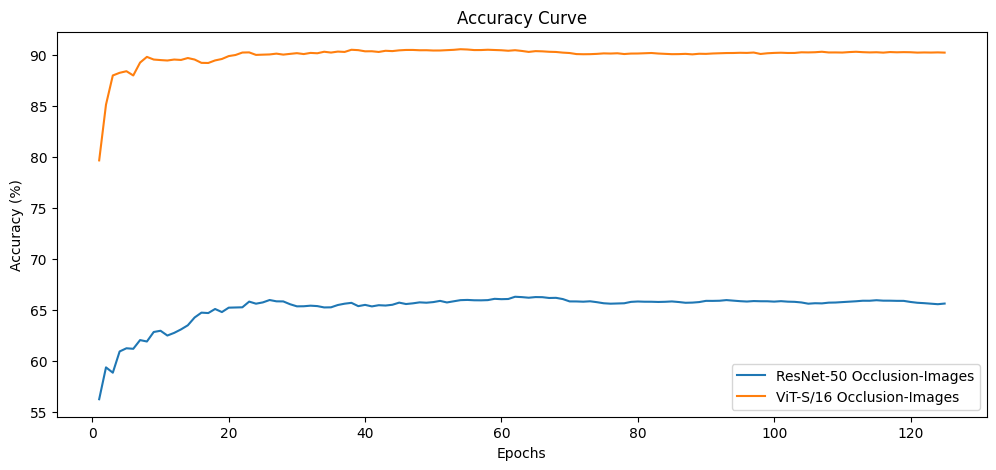

In [ ]:
plot_test_acc(resnet_shuffle_acc, "ResNet-50 Occlusion-Images", vit_shuffle_acc, "ViT-S/16 Occlusion-Images")

#####Baseline Vs Shuffling Vs Occlusion Comparison

In [ ]:
resnet_shuffle_accuracy = sum(resnet_shuffle_acc) / len(resnet_shuffle_acc)
vit_shuffle_accuracy = sum(vit_shuffle_acc) / len(vit_shuffle_acc)

resnet_occ_accuracy = sum(resnet_occ_acc_list) / len(resnet_occ_acc_list)
vit_occ_accuracy = sum(vit_occ_acc_list) / len(vit_occ_acc_list)

resent_base_accuracy = sum(resnet_acc) / len(resnet_acc)
vit_base_accuracy = sum(vit_acc) / len(vit_acc)

print("📊 Occlusion / Permutation Robustness Test")
print("---------------------------------------------------------")
print(f"{'Model':<10} | {'Occluded Accuracy (%)':<20} | {'Shuffled Accuracy (%)':<20}")
print("---------------------------------------------------------")
print(f"{'ResNet-50':<10} | {resnet_occ_accuracy:<20.2f} | {resnet_shuffle_accuracy:<20.2f}")
print(f"{'ViT-S/16':<10} | {vit_occ_accuracy:<20.2f} | {vit_shuffle_accuracy:<20.2f}")
print("---------------------------------------------------------")

📊 Occlusion / Permutation Robustness Test
---------------------------------------------------------
Model      | Occluded Accuracy (%) | Shuffled Accuracy (%)
---------------------------------------------------------
ResNet-50  | 82.72                | 65.24               
ViT-S/16   | 98.30                | 90.01               
---------------------------------------------------------


####6. Feature Representation Analysis

In [ ]:
def extract_features(model, dataloader, model_type="resnet", max_batches=10):
    model.eval()
    features, labels = [], []

    with torch.no_grad():
        for i, (images, labs) in enumerate(dataloader):
            images = images.to(device)

            if model_type == "resnet":
                # Forward pass until avgpool
                x = model.conv1(images)
                x = model.bn1(x)
                x = model.relu(x)
                x = model.maxpool(x)
                x = model.layer1(x)
                x = model.layer2(x)
                x = model.layer3(x)
                x = model.layer4(x)
                x = model.avgpool(x)
                x = torch.flatten(x, 1)

            elif model_type == "vit":
                x = model.forward_features(images)  # timm ViT
                if x.dim() > 2:  # flatten if needed
                    x = x.mean(dim=1)

            features.append(x.cpu())
            labels.append(labs)

            if i >= max_batches:  # limit for speed
                break

    return torch.cat(features), torch.cat(labels)

In [ ]:
def reduce_and_plot(features, labels, title="t-SNE", method="tsne"):
    if method == "tsne":
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
    else:
        reducer = PCA(n_components=2)

    reduced = reducer.fit_transform(features)

    plt.figure(figsize=(7,6))
    scatter = plt.scatter(reduced[:,0], reduced[:,1], c=labels, cmap="tab10", s=10, alpha=0.7)
    plt.legend(*scatter.legend_elements(), bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(title)
    plt.show()


In [ ]:
# Extract features
resnet_feats, resnet_labels = extract_features(resnet50_finetuned_model, testloader, model_type="resnet")
vit_feats, vit_labels = extract_features(vit_finetuned_model, testloader, model_type="vit")

#####a. t-SNE Plots

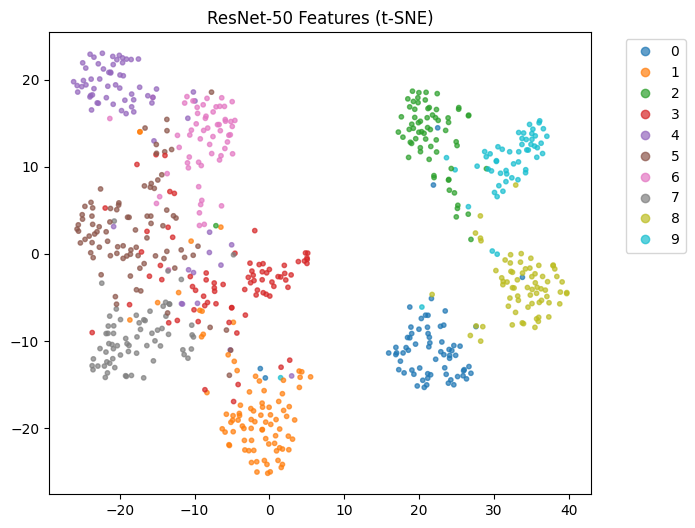

In [ ]:
reduce_and_plot(resnet_feats.numpy(), resnet_labels.numpy(), title="ResNet-50 Features (t-SNE)", method="tsne")

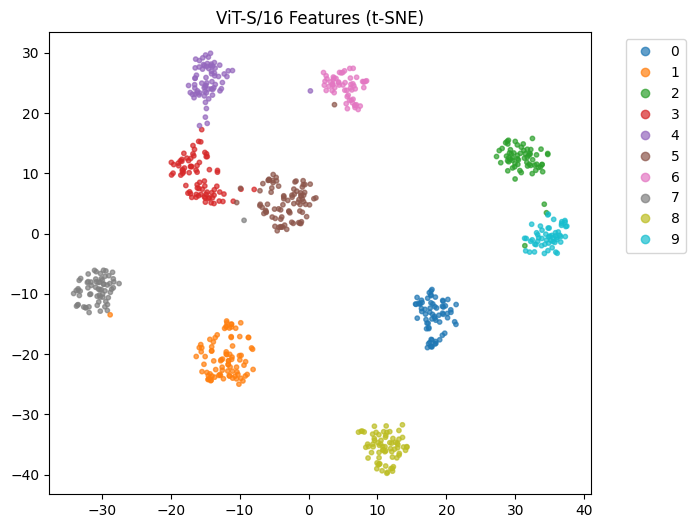

In [ ]:
reduce_and_plot(vit_feats.numpy(), vit_labels.numpy(), title="ViT-S/16 Features (t-SNE)", method="tsne")

#####b. PCA Plots

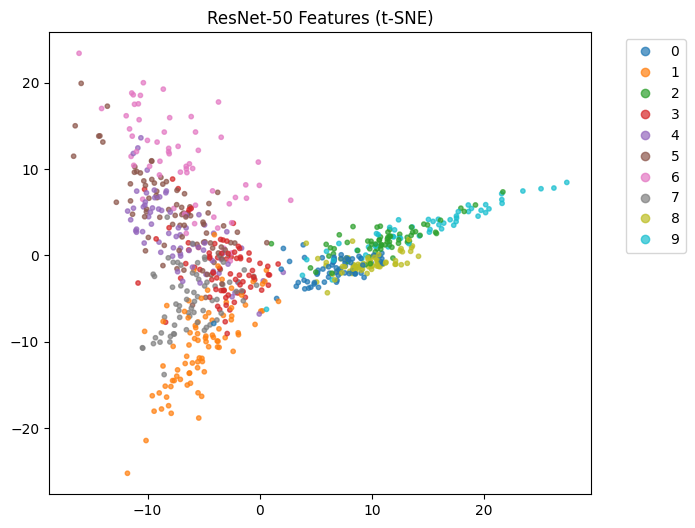

In [ ]:
reduce_and_plot(resnet_feats.numpy(), resnet_labels.numpy(), title="ResNet-50 Features (t-SNE)", method="pca")


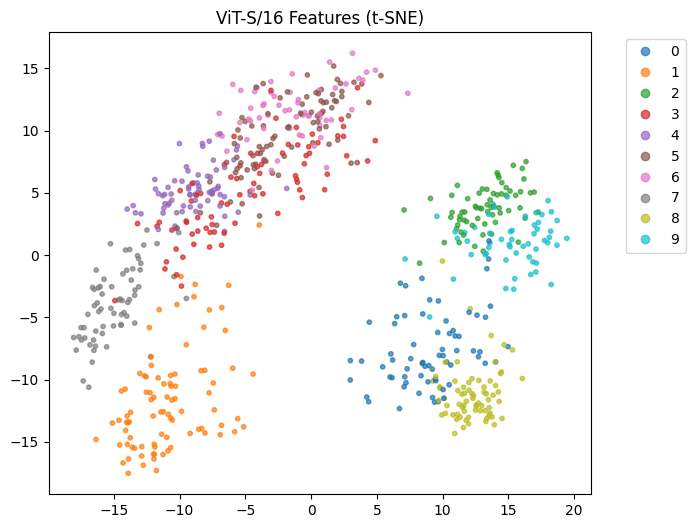

In [ ]:
reduce_and_plot(vit_feats.numpy(), vit_labels.numpy(), title="ViT-S/16 Features (t-SNE)", method="pca")

####7. Domain Generalization Test on PACS

#####a. Load Dataset from HuggingFace

In [ ]:
# Load PACS from Hugging Face
dataset = load_dataset("flwrlabs/pacs")

print(dataset)


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9991 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'domain', 'label'],
        num_rows: 9991
    })
})


#####b. Transform HuggingFace Dataset to Torch Dataset

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Hugging Face dataset -> Torch Dataset
class PACSDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample["image"].convert("RGB")
        label = sample["label"]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
def build_dataloaders(dataset, source_domains, target_domain, batch_size=64):
    # Filter HuggingFace dataset by domain
    source_data = dataset.filter(lambda x: x["domain"] in source_domains)
    target_data = dataset.filter(lambda x: x["domain"] == target_domain)

    # Wrap as torch Dataset
    source_dataset = PACSDataset(source_data, transform=train_transform)
    target_dataset = PACSDataset(target_data, transform=test_transform)

    # Build loaders
    train_loader = DataLoader(source_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(target_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

#####c. Train Models

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(train_loader):.4f}")
    return model

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

In [ ]:
num_classes = 7  # PACS has 7 categories

resnet50_base_model_7 = resnet50(weights=weights_default).to(device)
resnet50_base_model_7.fc = nn.Linear(resnet50_base_model_7.fc.in_features, num_classes)
resnet50_base_model_7.to(device)


vit_base_model_7 = timm.create_model("vit_small_patch16_224", pretrained=True, num_classes=num_classes)
vit_base_model_7.to(device)


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [ ]:
domains = ["art_painting", "cartoon", "photo", "sketch"]
results = []

for target in domains:
    source = [d for d in domains if d != target]
    print(f"\n🌍 Training on {source}, Testing on {target}")

    train_loader, test_loader = build_dataloaders(dataset["train"], source, target, batch_size=64)

    # ResNet
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(resnet50_base_model_7.parameters(), lr=1e-4)
    resnet50_finetuned_7 = train_model(resnet50_base_model_7, train_loader, test_loader, criterion, optimizer, epochs=5)
    resnet_acc_pacs = evaluate(resnet50_finetuned_7, test_loader)

    # ViT
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(vit_base_model_7.parameters(), lr=1e-4)
    vit_finetuned_7 = train_model(vit_base_model_7, train_loader, test_loader, criterion, optimizer, epochs=5)
    vit_acc_pacs = evaluate(vit_finetuned_7, test_loader)

    results.append((target, resnet_acc_pacs, vit_acc_pacs))
    print(f"📊 Results on {target} | ResNet-50: {resnet_acc_pacs:.2f}% | ViT-S/16: {vit_acc_pacs:.2f}%")



🌍 Training on ['cartoon', 'photo', 'sketch'], Testing on art_painting


Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Epoch 1/5 | Loss: 0.8380
Epoch 2/5 | Loss: 0.3433
Epoch 3/5 | Loss: 0.2859
Epoch 4/5 | Loss: 0.2483
Epoch 5/5 | Loss: 0.2346
Epoch 1/5 | Loss: 0.6157
Epoch 2/5 | Loss: 0.3315
Epoch 3/5 | Loss: 0.2611
Epoch 4/5 | Loss: 0.2404
Epoch 5/5 | Loss: 0.2337
📊 Results on art_painting | ResNet-50: 75.34% | ViT-S/16: 82.37%

🌍 Training on ['art_painting', 'photo', 'sketch'], Testing on cartoon


Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Epoch 1/5 | Loss: 0.3148
Epoch 2/5 | Loss: 0.2380
Epoch 3/5 | Loss: 0.2332
Epoch 4/5 | Loss: 0.2117
Epoch 5/5 | Loss: 0.2065
Epoch 1/5 | Loss: 0.2892
Epoch 2/5 | Loss: 0.2324
Epoch 3/5 | Loss: 0.2329
Epoch 4/5 | Loss: 0.1961
Epoch 5/5 | Loss: 0.1962
📊 Results on cartoon | ResNet-50: 94.97% | ViT-S/16: 94.16%

🌍 Training on ['art_painting', 'cartoon', 'sketch'], Testing on photo


Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Epoch 1/5 | Loss: 0.2407
Epoch 2/5 | Loss: 0.2330
Epoch 3/5 | Loss: 0.2060
Epoch 4/5 | Loss: 0.2078
Epoch 5/5 | Loss: 0.1859
Epoch 1/5 | Loss: 0.2131
Epoch 2/5 | Loss: 0.1937
Epoch 3/5 | Loss: 0.2028
Epoch 4/5 | Loss: 0.1940
Epoch 5/5 | Loss: 0.1829
📊 Results on photo | ResNet-50: 99.82% | ViT-S/16: 99.22%

🌍 Training on ['art_painting', 'cartoon', 'photo'], Testing on sketch


Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Epoch 1/5 | Loss: 0.1600
Epoch 2/5 | Loss: 0.1424
Epoch 3/5 | Loss: 0.1340
Epoch 4/5 | Loss: 0.1107
Epoch 5/5 | Loss: 0.1162
Epoch 1/5 | Loss: 0.1213
Epoch 2/5 | Loss: 0.1230
Epoch 3/5 | Loss: 0.1044
Epoch 4/5 | Loss: 0.1139
Epoch 5/5 | Loss: 0.1000
📊 Results on sketch | ResNet-50: 98.45% | ViT-S/16: 94.10%


#####d. Comparison of Results

In [ ]:
df = pd.DataFrame(results, columns=["Held-out Domain", "ResNet-50 Acc", "ViT-S/16 Acc"])
print("\nFinal Domain Generalization Results")
print(df)



Final Domain Generalization Results
  Held-out Domain  ResNet-50 Acc  ViT-S/16 Acc
0    art_painting      75.341797     82.373047
1         cartoon      94.965870     94.155290
2           photo      99.820359     99.221557
3          sketch      98.447442     94.095190


#####e. Accuracy Drop Test

In [ ]:
def accuracy_drop(model, dataset, source_domains, target_domain, batch_size=64):
    # Build loaders
    source_data = dataset.filter(lambda x: x["domain"] in source_domains)
    target_data = dataset.filter(lambda x: x["domain"] == target_domain)

    source_dataset = PACSDataset(source_data, transform=test_transform)
    target_dataset = PACSDataset(target_data, transform=test_transform)

    source_loader = DataLoader(source_dataset, batch_size=batch_size, shuffle=False)
    target_loader = DataLoader(target_dataset, batch_size=batch_size, shuffle=False)

    # Evaluate
    src_acc = evaluate(model, source_loader)
    tgt_acc = evaluate(model, target_loader)
    drop = abs(src_acc - tgt_acc)

    return src_acc, tgt_acc, drop

In [ ]:
domains = ["art_painting", "cartoon", "photo", "sketch"]

acc_drop_results = []
for target in domains:
    source = [d for d in domains if d != target]

    resnet_src_acc, resnet_tgt_acc, resnet_drop = accuracy_drop(resnet50_finetuned_7, dataset["train"], source, target)
    vit_src_acc, vit_tgt_acc, vit_drop = accuracy_drop(vit_finetuned_7, dataset["train"], source, target)

    print(f"\nHeld-out = {target}")
    print(f"ResNet-50 | Source: {resnet_src_acc:.2f}% | Target: {resnet_tgt_acc:.2f}% | Drop: {resnet_drop:.2f}%")
    print(f"ViT-S/16  | Source: {vit_src_acc:.2f}% | Target: {vit_tgt_acc:.2f}% | Drop: {vit_drop:.2f}%")

    acc_drop_results.append({"target": target, "resnet_src": resnet_src_acc, "resnet_tgt": resnet_tgt_acc, "resnet_drop": resnet_drop, "vit_src": vit_src_acc, "vit_tgt": vit_tgt_acc, "vit_drop": vit_drop})


Held-out = art_painting
ResNet-50 | Source: 99.14% | Target: 99.85% | Drop: 0.71%
ViT-S/16  | Source: 96.94% | Target: 99.17% | Drop: 2.23%

Held-out = cartoon
ResNet-50 | Source: 99.16% | Target: 99.70% | Drop: 0.54%
ViT-S/16  | Source: 96.63% | Target: 99.91% | Drop: 3.29%


Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]


Held-out = photo
ResNet-50 | Source: 99.15% | Target: 100.00% | Drop: 0.85%
ViT-S/16  | Source: 96.98% | Target: 99.46% | Drop: 2.48%


Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]


Held-out = sketch
ResNet-50 | Source: 99.84% | Target: 98.45% | Drop: 1.39%
ViT-S/16  | Source: 99.54% | Target: 94.10% | Drop: 5.44%


####

####